#**BIF TRANSLATOR**
A project by:
Acquadro Patrizio - 502311
Uttini Lorenzo - 502183

In this colab notebook we perform a machine translation task, using the Keras library to exploit the different architectures, useful to accomplish this task.


##***INITIATION***
We install the packages we need and we import all the different methods and functions that we need in the respective coding blocks.

In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.8 MB/s eta 0:00:00


In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 8.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import GRU, LSTM, Embedding, Bidirectional, Input, Dropout, Dense

import requests
import io
import zipfile

import random
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.translate import meteor_score
from nltk import FreqDist
import jiwer

import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import GRU, LSTM, Embedding, Bidirectional, Input, Dropout, Dense

import sacrebleu

###***Read the file***
We loaded the file zipped on github. <br>
Then, we read the file from our github link and we unzip it.

In [90]:
# Read the file
url = "https://github.com/lorenzouttini/Exam_NLP/raw/main/ita-eng.zip"
response = requests.get(url)

#Unzip the file
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall()

# Preprocessing of the text


### Construct the list of the pairs

We call our text **"text_file"**. <br>


Since the original text contains the english sentences paired with the italian ones(separated by a "*tab*" character), we have created a list called **"list_pairs"** where we put the tuples composed by the english sentence and the translated italian one.  <br>


In the italian translation we have added the start and end **tokens**.

In [ ]:
# Instantiate the file
text_file = "ita.txt"

In [ ]:
# Open it
with open("ita.txt", "r") as file:
    lines = file.readlines()

# Created our new dataset composed by english and italian sentences seperated
pairs_list = []
for line in lines:
    parts = line.split("\t")
    if len(parts) >= 2:
        english = parts[0].strip()
        italian = parts[1].strip()
        italian = "[start] " + italian + " [end]"     # starting and ending tokens
        pairs_list.append((english, italian))          # append to the list the pairs (english/italian)

print(pairs_list[:5])
print(len(pairs_list))

[('Hi.', '[start] Ciao! [end]'), ('Hi.', '[start] Ciao. [end]'), ('Run!', '[start] Corri! [end]'), ('Run!', '[start] Corra! [end]'), ('Run!', '[start] Correte! [end]')]
364200


In [ ]:
# Randomly remove 80% of the elements
pairs_list = random.sample(pairs_list, k=int(0.8 * len(pairs_list)))

print(len(pairs_list))

291360


### Analyzing the dataset

We compute some statistics for Italian and English sentences and words, to analyze completely the dataset that we have.

These statistics, for both the italian and the english words and sentences, are:
- the total number of both
- the mean of both
- the maximum lenght of a sentence
- the number of unique words

Then we've plotted also their distributions with the respective mean

And at the end we also plot the graph derived from the Zipf's law, to display the words according to their rank, based on their frequency



####**Statistics for Italian sentences:**

In [ ]:
nltk.download('punkt')

# Tokenize the Italian words
words_ita = [word.lower() for pair in pairs_list for word in nltk.word_tokenize(pair[1])]

# Filter out the special tokens
filtered_words = [word for word in words_ita if word not in ["[", "]", "start", "end"]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Compute Italian statistics
total_word_ita = len(filtered_words)
total_sentences_ita = len(pairs_list)
mean_word_length_ita = round(sum(len(word) for word in filtered_words) / total_word_ita)
mean_sentence_length_ita = round(total_word_ita / total_sentences_ita)
unique_words_ita = len(set(filtered_words))

# Print the Italian statistics
print("Total number of Italian words (excluding tokens):", total_word_ita)
print("Total number of sentences:", total_sentences_ita)
print("Mean length of Italian words (excluding tokens):", mean_word_length_ita)
print("Mean length of Italian sentences:", mean_sentence_length_ita)
print("Number of unique Italian words (excluding tokens):", unique_words_ita)

Total number of Italian words (excluding tokens): 1889125
Total number of sentences: 291360
Mean length of Italian words (excluding tokens): 4
Mean length of Italian sentences: 6
Number of unique Italian words (excluding tokens): 27191


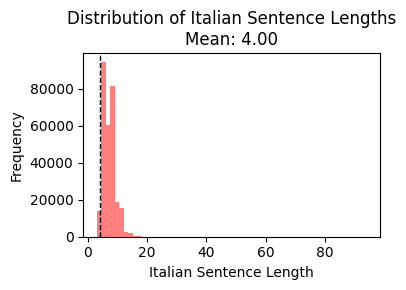

In [ ]:
#ITALIAN SENTENCE LENGHT DISTRIBUTION
italian_lengths = []

for pair in pairs_list:
    italian_sentence = pair[1]
    italian_length = len(italian_sentence.split())
    italian_lengths.append(italian_length)

#Compute the mean
mean_italian_length = round(sum(len(word) for word in filtered_words) / total_word_ita)

# Create the subplot
plt.figure(figsize=(4, 3))

# Plot of the distribution
plt.hist(italian_lengths, bins=60, color='red', alpha=0.5)
plt.axvline(mean_italian_length, color='black', linestyle='dashed', linewidth=1)
plt.xlabel('Italian Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Italian Sentence Lengths\nMean: {:.2f}'.format(mean_italian_length))

# Print the graph
plt.tight_layout()
plt.show()


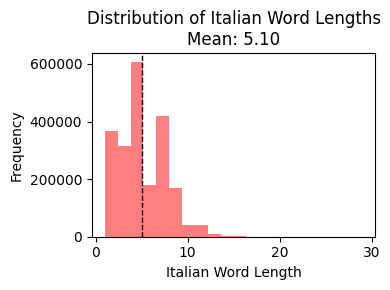

In [ ]:
#ITALIAN WORDS LENGHT DISTRIBUTION
italian_word_lengths = []

for pair in pairs_list:
    italian_sentence = pair[1]
    italian_words = italian_sentence.split()

    for word in italian_words:
        italian_word_lengths.append(len(word))

# Compute the mean
mean_italian_word_length = sum(italian_word_lengths) / len(italian_word_lengths)

# Create a subplot
plt.figure(figsize=(4, 3))

# Plot of the distribution
plt.hist(italian_word_lengths, bins=20, color='red', alpha=0.5)
plt.axvline(mean_italian_word_length, color='black', linestyle='dashed', linewidth=1)
plt.xlabel('Italian Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Italian Word Lengths\nMean: {:.2f}'.format(mean_italian_word_length))

#Display the graph
plt.tight_layout()
plt.show()


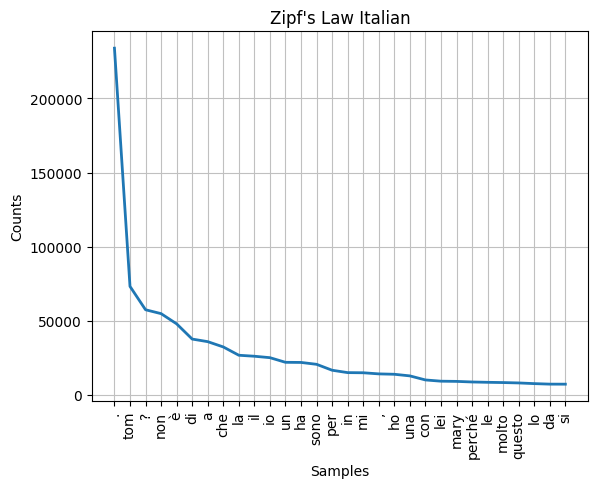

In [ ]:
# Plot Zipf's Law graph
fdist = FreqDist(filtered_words)
plt.title("Zipf's Law Italian")
fdist.plot(30, cumulative=False)
plt.show()

####**Statistics for English sentences:**

In [ ]:
nltk.download('punkt')

# Tokenize the English words
words_eng = [word.lower() for pair in pairs_list for word in nltk.word_tokenize(pair[0])]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Compute English statistics
total_word_eng = len(words_eng)
total_sentences_eng = len(pairs_list)
mean_word_length_eng = round(sum(len(word) for word in words_eng) / total_word_eng)
mean_sentence_length_eng = round(total_word_eng / total_sentences_eng)
unique_words_eng = len(set(words_eng))

# Print the English statistics
print("Total number of words (excluding tokens):", total_word_eng)
print("Total number of sentences:", total_sentences_eng)
print("Mean length of words (excluding tokens):", mean_word_length_eng)
print("Mean length of sentences:", mean_sentence_length_eng)
print("Number of unique words (excluding tokens):", unique_words_eng)

Total number of words (excluding tokens): 2020048
Total number of sentences: 291360
Mean length of words (excluding tokens): 3
Mean length of sentences: 7
Number of unique words (excluding tokens): 13406


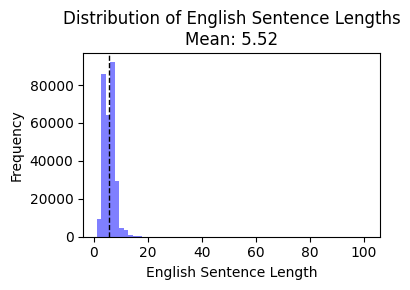

In [ ]:
#ITALIAN SENTENCE LENGHT DISTRIBUTION
english_lengths = []

for pair in pairs_list:
    english_sentence = pair[0]
    english_length = len(english_sentence.split())
    english_lengths.append(english_length)

#Compute the mean
mean_english_length = sum(english_lengths) / len(english_lengths)

# Create a subplot
plt.figure(figsize=(4, 3))

# Plot of the distribution
plt.hist(english_lengths, bins=60, color='blue', alpha=0.5)
plt.axvline(mean_english_length, color='black', linestyle='dashed', linewidth=1)
plt.xlabel('English Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of English Sentence Lengths\nMean: {:.2f}'.format(mean_english_length))

#Display the graph
plt.tight_layout()
plt.show()


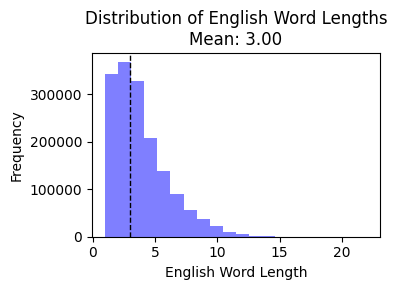

In [ ]:
#ENGLISH WORDS LENGHT DISTRIBUTION
english_word_lengths = []

for pair in pairs_list:
    english_sentence = pair[0]
    english_words = english_sentence.split()

    for word in english_words:
        english_word_lengths.append(len(word))

#Compute the mean
mean_english_word_length = round(sum(len(word) for word in words_eng) / total_word_eng)

#Create a subplot
plt.figure(figsize=(4, 3))

# Plot of the distribution
plt.hist(english_word_lengths, bins=20, color='blue', alpha=0.5)
plt.axvline(mean_english_word_length, color='black', linestyle='dashed', linewidth=1)
plt.xlabel('English Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of English Word Lengths\nMean: {:.2f}'.format(mean_english_word_length))

#Display the graph
plt.tight_layout()
plt.show()


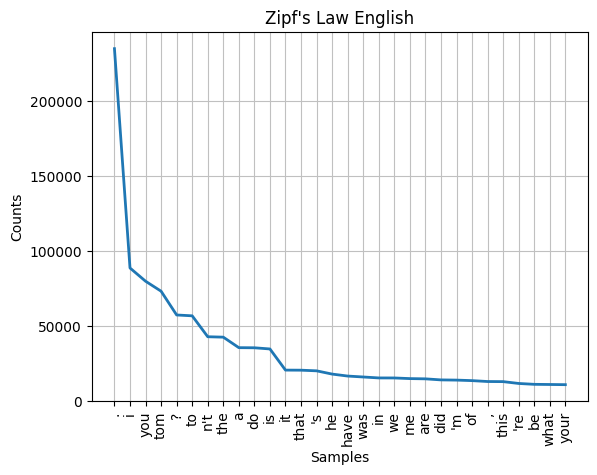

In [ ]:
# Plot Zipf's Law graph
fdist = FreqDist(words_eng)
plt.title("Zipf's Law English")
fdist.plot(30, cumulative=False)
plt.show()

### Train, Validation and Test
We have defined the proportion of the train, validation and test set:
- **Train**: 70%
- **Validation**: 15%
- **Test**: 15%

It is important to notice that the senteces in the original text were ordinated incrementally with the respect to the length. So choose to **shuffle** the dataset before defining training, validation and test.

We've already picked randomly the sentences to form the dataset with 80% of the original samples, so this is not necessary, but we've made it to generalize the case.

In [ ]:
# Shuffle the pairs
random.shuffle(pairs_list)

# Define the dimensions
dim_val = int(0.15 * len(pairs_list))               # define the validation samples (15%)
dim_train = len(pairs_list) - 2 * dim_val   # define the train samples (70%)

In [ ]:
# Define the train, validation and test set pairs
train_pairs = pairs_list[:dim_train]
val_pairs = pairs_list[dim_train:dim_train + dim_val]
test_pairs = pairs_list[dim_train + dim_val:]

### Prepare Word Vectorization

Firstly, we define the punctuation signs with variable **"punctuation_chars"**. <br>

Since in the tokens (start, end) we have the square brackets, we choose to replace '**[**' , '**]**' with the empty string to keep them then, when we remove the punctuation. <br>

Then, we create a function "**custom_remove**" that put all the characters in lower case and remove the punctuations we have defined previously. <br>

We have defined a **dictionary size** that indicates the number of unique words that the model take in consideration during training of translation. <br>

After this, we decided to set the sequence lenght to **15**, that corresponds to the number of tokens processed by each RNN unit.
- A <u>larger size</u> could deal better the context to generate more elaborated sentences, but requires more computational resources.
- A <u>smaller size</u> could generate more fluent and coherent texts, but it does not consider to much the context.

In [ ]:
# Define punctuation signs
punctuation_chars = string.punctuation

# Keep square brackets
punctuation_chars = punctuation_chars.replace("[", "")
punctuation_chars = punctuation_chars.replace("]", "")

In [ ]:
# Remove all the punctuation signs we have defined
def custom_remove(input_string):
  lowercase = tf.strings.lower(input_string)
  return tf.strings.regex_replace(lowercase, f"[{re.escape(punctuation_chars)}]", "")    # keep square brackets

In [ ]:
# Define Vocabulary and Sequence lenght
dictionary_size = 25000
sequence_size = 15

For the pre-processing of text we decide to use an integrated function of keras called TextVectorization, that **remove punctuation** signs and form the new **vocabulary** based on our training sentences. <br>

The TextVectorization English layer takes as parameters the "**dictionary_size**" and "**window_size**". <br>
The Italian Layer has the same parameters of the previous one but it adds one unit to "**output_sequence_lenght**" (because of the end token) and it introduces a new parameter called "**standardize**" that modify the text with the function we have defined previously ("custom_remove").  <br>


Then, we make a list of all the <u>training sentences</u> (english and italian) and we adapt the Vectorization Layers we have defined on these training lists. <br>
This means that all the sentences are turned into **vectors** (dimension=15) of integers which correspond to the words index in the vocabulary.



In [ ]:
# English layer
eng_vectorization = layers.TextVectorization(
 max_tokens= dictionary_size,
 output_mode="int",
 output_sequence_length=sequence_size,
)

In [ ]:
# Italian layer
ita_vectorization = layers.TextVectorization(
 max_tokens= dictionary_size,
 output_mode="int",
 output_sequence_length=sequence_size + 1,     # output consider also ['end'] token
 standardize=custom_remove,                    # remove punctuations and keep square brackets
)

In [ ]:
# Create training lists
train_english_list = [pair[0] for pair in train_pairs]
train_italian_list = [pair[1] for pair in train_pairs]

print(train_english_list[2])
print(train_italian_list[2])

That's part of our job.
[start] Fa parte del nostro lavoro. [end]


In [ ]:
# Apply vectorization layers on our training lists --> as output we obtain only vectors of 25 integers components
eng_vectorization.adapt(train_english_list)
ita_vectorization.adapt(train_italian_list)

# Prepare datasets for the translation

Now our aim is to create the validation and training dataset for the translation tasks, by vectoring them. To make this, we create two functions: <br>

**1. "format_dataset**": with english and italian Vectorization Layers defined before, we preprocess the parameters of the function (eng, ita). We return english proprocessed text and italian preprocessed text of the same lenght (for this reason we remove one dimension from the input and output italian). <br>


**2. "make_dataset"**: it is the function that creates the real dataset. It takes as a parameter "*pairs*" that corresponds to the list of sets formed by pairs. It divides pairs in different elements and transform them in lists. Then, it creates the **dataset** from the two lists (with a special tensorflow dataset). Finally, it formatted the dataset according to the batch size and to the function "*format_dataset*" we have defined above. Moreover, we have used the function "*shuffle*" to introduce some randomness in the dataset, "*prefetch*" to reduce the time for training and "*cache*" to save the data locally to optimize the training performances. <br>

As last step, we define the ***train*** and ***validation*** dataset with the method we have described above.

In [ ]:
# Define batch size
batch_size = 64

# Create the function to format the dataset
def format_dataset(eng, ita):
  eng = eng_vectorization(eng)
  ita = ita_vectorization(ita)
  return ({"english": eng, "italian": ita[:, :-1], },
          ita[:, 1:])

In [ ]:
# Create the function to make the dataset
def make_dataset(set_pairs):
  eng_, ita_ = zip(*set_pairs)
  eng_ = list(eng_)
  ita_ = list(ita_)
  dataset = tf.data.Dataset.from_tensor_slices((eng_, ita_))   #Define the dataset from Tensorflow
  dataset = dataset.batch(batch_size)                          #Adapt the dataset with dimension of batch
  dataset = dataset.map(format_dataset, num_parallel_calls=4)  #Map the dataset with the function format_dataset
  return dataset.shuffle(2048).prefetch(16).cache()

In [ ]:
# Define the train and validation datasets
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
# Define the first element
first_element = train_ds.take(1)

# Iterate over the first_element dataset and print each element
for eng_text, ita_text in first_element:
    print("English Text:", eng_text)
    print("Italian Text:", ita_text)

English Text: {'english': <tf.Tensor: shape=(64, 15), dtype=int64, numpy=
array([[   25,   248,     7,  1145,    19,    72,    50,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    3,   115,   118,   250,     6,   913,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    3,    51,     5,     9,    13,    55,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   44,     2,   541,    15,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    4,    90,    47,     6,   231,   393,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    4,    44,     9,    97,   296,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   25,   366,    24,   316,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   76,     3,    18,   955,     0,     0,     0,     0,     0,
 

In [ ]:
# Print the shape of each element
for inputs, targets in first_element:
  print(f"inputs['english'].shape: {inputs['english'].shape}")
  print(f"inputs['italian'].shape: {inputs['italian'].shape}")
  print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 15)
inputs['italian'].shape: (64, 15)
targets.shape: (64, 15)


#***RNN: BIDIRECTIONAL WITH GRU***

# Definition of the RNN decoder and encoder

In this part we've defined the **first model** to perform the task of translation. <br>

Firstly, we have defined the **ENCODER** with different layers:
- **Input Layer**: it defines the input of the encoder (English sentences). The *"shape"* = (None,) indicates that the sequences could be various lengths.
- **Embedding Layer**: from our vectors of dimension (64,25), it creates 30000 (dictionary_size) embeddings of dimensions 256. The parameter "*mask_zero*"= **True** allows the embedding to not consider the 0s elements of the input vectors (because Text Vectorization layer have padded the sequences < 25 words).
- **Bidirectional Layer**: it is a bidirectional RNN unit that works with 2 GRU. The output of the two GRU will be summed (*merge_mode = 'sum'*). <br>

Then, we've defined the **DECODER** with some layers:
 - **Input Layer**: it has the same function of the encoder's one but we give as inputs Italian sentences (that are the actual target).
 - **Embedding Layer**: it has the same functions of the encoder's one.
 - **GRU Layer**: it is a RNN unit that has as *input* the Italian sentence (actual target) and as parameter "*hidden_state*" the output of the encoder part (which corresponds to the initial state of the decoder).
 - **Dropout Layer**: it removes temporarily 50% of the units during training to avoid overfitting.
 - **Dense Laye**r: it is a classic *Multilayer Perceptron* that allows the prediction of the next token through the softmax (as *activation function*).

In [ ]:
# Define Embedding dimension and Latent dimension
embed_dim = 256
hid_dim = 1024

In [ ]:
# Bidirectional based encoder
input_eng = Input(shape=(None,), dtype="int64", name="english")
embedding_enc = Embedding(dictionary_size, embed_dim, mask_zero=True)(input_eng)
encoded_source = Bidirectional(GRU(hid_dim), merge_mode="sum")(embedding_enc)

In [ ]:
# GRU based decoder
input_ita = Input(shape=(None,), dtype="int64", name="italian")
embedding_dec = Embedding(dictionary_size, embed_dim, mask_zero=True)(input_ita)
decoder_gru = GRU(hid_dim, return_sequences=True)
dec_gru = decoder_gru(embedding_dec, initial_state=encoded_source)
dropout = Dropout(0.5)(dec_gru)
output_target = Dense(dictionary_size, activation="softmax")(dropout)

# Define the model, compile and train it

We have defined the model (encoder and decoder) calling it 'model_seq2seq_GRU'.

In the compiling part we choose as **optimizer** '*adam*', as **loss** '*sparse_categorical_crossentropy*' and as **metrics** '*accuracy*'. <br>
Then, we **train** the model and we see the performance also on the **Validation** set.

In [ ]:
#Define the model
model_seq2seq_GRU = Model([input_eng, input_ita], output_target)

In [ ]:
model_seq2seq_GRU.compile(
 optimizer="adam",
 loss="sparse_categorical_crossentropy",
 metrics=['accuracy'])

In [ ]:
GRU_history = model_seq2seq_GRU.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
3187/3187 [==============================] - 387s 115ms/step - loss: 2.7673 - accuracy: 0.5409 - val_loss: 1.4888 - val_accuracy: 0.7013
Epoch 2/5
3187/3187 [==============================] - 337s 106ms/step - loss: 1.2865 - accuracy: 0.7229 - val_loss: 1.0581 - val_accuracy: 0.7661
Epoch 3/5
3187/3187 [==============================] - 332s 104ms/step - loss: 0.9134 - accuracy: 0.7756 - val_loss: 0.9439 - val_accuracy: 0.7867
Epoch 4/5
3187/3187 [==============================] - 330s 103ms/step - loss: 0.7498 - accuracy: 0.8007 - val_loss: 0.9052 - val_accuracy: 0.7953
Epoch 5/5
3187/3187 [==============================] - 329s 103ms/step - loss: 0.6565 - accuracy: 0.8165 - val_loss: 0.8943 - val_accuracy: 0.7994


#***TRANSFORMERS***

We're defining the transformer architecture, to perform the machine translation task, instead of using the RNN models. <br>
This because we want to exploit the parallelization to generate a more natural and human-like translation, but also to speed up the process.<br>
And also because we want to detect correctly the long-term dependencies of the sentence's terms.

So, at first, to define the architecture we define 3 different classes:
- Positional Embedding: to be aware of the position of the tokens in the input sentence
- Transformer Encoder: to set up the encoder of the transformer model, since we are in a seq-2-seq task.
- Transformer Decoder: to set up the decoder of the transformer, in order to make the translation of the input sentence.

To design all this, we've looked at the Keras documentation on Transformers, available online.

### ***Positional Embedding***
This embedding is used to be aware of the *position of the tokens* is the sentence, which is fundamental to get a right translation. <br>
This has to be done, since we provide to the model all the tokens embeddings in parallel, so regardless their position.

We've *different method* to define this class:
- **init**: we intialize the class's attributes, that define all the elements that we need, including token embedding and the position embedding.
- **call**: method to return the sum of the token embedding and the positional embedding(embedding vectors), based on the input what we pass as parameter.
- **compute_mask**: generate mask to ignore the 0s padding that we have made when we've set the sequence lenght equal to 15 also for sequence with less than 15 tokens.
- **get_config**: to save this configuration and to use it when we call it in other layers.

In [ ]:
class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding(input_dim=input_dim,
                                             output_dim=output_dim)
    self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                output_dim=output_dim)
    self.sequence_length = sequence_length
    self.input_dim = input_dim
    self.output_dim = output_dim

  def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
    config = super().get_config()
    config.update({
      "output_dim": self.output_dim,
      "sequence_length": self.sequence_length,
      "input_dim": self.input_dim,})
    return config

###***Transformer Encoder***
In a seq-2-seq model we have at first an **encoder**, to get the parsed representation of the entire input sequence.

At first we use **multi head attention layer**, to understand which parts of the sentence are more related to each word of the sentence. <br>
We obtain a vector that we combine with the original input vector, using a skip connection. <br>
Then we normalize using the **layerNormalization**.

Then we process this with a **feed-forward network**(MLP) with 2 dense layers. <br>
The output that we obtain is then added with again the input vector, using another skip connection, and this sum will be normalized using a **layerNormalization**.

This will be the input of the decoder part.

We have different methods to define this clas:
- init: where we've defined all the layers described above.
- call: performs all the computations, so computes the attention output, the projection input(after the addition of the input vector and normalization), the projection output and the normalized sum of this latter with the input vector.
- get_config: returns a dictionary which is the encoder configuration, used when we call the encoder in the model.

In [ ]:
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(num_heads=num_heads,
                                               key_dim=embed_dim)
    self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),
                                        layers.Dense(embed_dim),])
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()

  def call(self, inputs, mask=None):
    if mask is not None:
      mask = mask[:, tf.newaxis, :]
    attention_output = self.attention(
      inputs, inputs, attention_mask=mask)
    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)

  def get_config(self):
    config = super().get_config()
    config.update({
      "embed_dim": self.embed_dim,
      "num_heads": self.num_heads,
      "dense_dim": self.dense_dim,
    })
    return config

Now, since we've defined the **encoder**, we define the **decoder**, to get the predicted translated sentence.

As with the encoder, we have at first to define **multi head attention layer**, but in this case are 2 different layers, each followed by a combination with the original target vector, using a skip connection. <br>
For the second multi-head attention layer we have also as input the output of the encoder.<br>
And then we normalize using the **layerNormalization**, as with the encoder.

Then we process this with a **feed-forward network**(MLP) with 2 dense layers. <br>
The output that we obtain is then added with again the target vector, using another skip connection, and this sum will be normalized using a **layerNormalization**.

The output of the decoder will be the input of a linear layer, followed by a softmax layer, that will output the probability distribution of the predicted token. <br>
All these tokens will composed the predicted translated sentence.

We have different methods to define this clas:
- init: where we've defined all the layers described above.
- call: performs all the computations that we've defined. In particular, as the first step, it prepares the input mask, which describes the padding location in the target. This will be passed to the first attention layer, which performes self-attention over the target sequence.
- get_causal_attention_mask: used to look with attention only the words before the last one, the one we focus on, for which we compute the attention mechanism. This because we are in the decoder and we can't look the whole target sentence, but only the words already predicted.
- get_config: returns a dictionary which is the encoder configuration, used when we call the encoder in the model.

In [ ]:
class TransformerDecoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_dim)
    self.attention_2 = layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_dim)
    self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim, activation="relu"),
        layers.Dense(embed_dim),]
        )
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()
    self.supports_masking = True

  def get_config(self):
    config = super().get_config()
    config.update({
      "embed_dim": self.embed_dim,
      "num_heads": self.num_heads,
      "dense_dim": self.dense_dim,
      })
    return config

  def get_causal_attention_mask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i >= j, dtype="int32")
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat([tf.expand_dims(batch_size, -1),
                      tf.constant([1, 1], dtype=tf.int32)], axis=0)
    return tf.tile(mask, mult)

  def call(self, inputs, encoder_outputs, mask=None):
    causal_mask = self.get_causal_attention_mask(inputs)
    if mask is not None:
      padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
      padding_mask = tf.minimum(padding_mask, causal_mask)
    attention_output_1 = self.attention_1(query=inputs,
                                          value=inputs,
                                          key=inputs,
                                          attention_mask=causal_mask)
    attention_output_1 = self.layernorm_1(inputs + attention_output_1)
    attention_output_2 = self.attention_2(query=attention_output_1,
                                          value=encoder_outputs,
                                          key=encoder_outputs,
                                          attention_mask=padding_mask,)
    attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)
    proj_output = self.dense_proj(attention_output_2)
    return self.layernorm_3(attention_output_2 + proj_output)

###***Creation of the model and training***
Now we create the transformer-model with the different layers.

We have defined:
- embedding dimension: the number of components of the embedding vector( 256)
- dense dimension: the number of neurons in each dense layer of the FFNN (2048)
- number of heads: number of times we perform the self-attention of the token, in order to focus on different parts of the taget sentence. We use 8, as was stated in the paper that introduced Transformers. This has to be a low number to keep interpretability.

In encoder part we have the input layer, which takes the embedding of the input token. <br>
Then we use the positional embedding layer, to create the embedding which takes into consideration the position of the tokens in the sentence.
Finally we use the encoder transformer, which creates the representation of the input.

In the decoder part we have, as in the encoder part, we have the input layer which takes as input the target token.
Then we have the positional embedding layer.
And, at the end, we have the decoder transformer, which takes as input the positional embedding and the output of the encoder.

At the end we have the dropout layer, to reduce the overfitting and make a more robust model; and the output layer with the softmax activation.

In the last line of the code we've created the transformer model.

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

#Encoder part
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
pos_embedding_enc = PositionalEmbedding(sequence_size, dictionary_size, embed_dim)(encoder_inputs)
encoder_transf = TransformerEncoder(embed_dim, dense_dim, num_heads)(pos_embedding_enc)

#Decoder part
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="italian")
pos_embedding_dec = PositionalEmbedding(sequence_size, dictionary_size, embed_dim)(decoder_inputs)
decoder_transf = TransformerDecoder(embed_dim, dense_dim, num_heads)(pos_embedding_dec, encoder_transf)
dropout = layers.Dropout(0.5)(decoder_transf)
decoder_outputs = layers.Dense(dictionary_size, activation="softmax")(dropout)

#Create the model
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

Now we compile the model, to transform it as a computational graph, with ADAM optimizer, sparse categorical cross entropy as Loss and precision as metrics.

Now we train the model, using the fit method.

In [ ]:
transformer.compile(
  optimizer="adam",
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"])

In [ ]:
transformer_history = transformer.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
3187/3187 [==============================] - 282s 84ms/step - loss: 2.3695 - accuracy: 0.6041 - val_loss: 1.3885 - val_accuracy: 0.7196
Epoch 2/5
3187/3187 [==============================] - 249s 78ms/step - loss: 1.2956 - accuracy: 0.7297 - val_loss: 1.1087 - val_accuracy: 0.7572
Epoch 3/5
3187/3187 [==============================] - 249s 78ms/step - loss: 1.0250 - accuracy: 0.7656 - val_loss: 0.9891 - val_accuracy: 0.7766
Epoch 4/5
3187/3187 [==============================] - 252s 79ms/step - loss: 0.8804 - accuracy: 0.7858 - val_loss: 0.9312 - val_accuracy: 0.7864
Epoch 5/5
3187/3187 [==============================] - 263s 82ms/step - loss: 0.7867 - accuracy: 0.7998 - val_loss: 0.8957 - val_accuracy: 0.7928


##**EVALUATION***

###***HUMAN EVALUATION WITH GRU***
####**Decode the predicted sequences**

We created a function "*decode_sequence*" to predict the translated sequences. As input we give some test instances that were originally showed as sets text pairs-<br>
 So, we tokenized and transformed them in vectors (input senteces, target sentences) with the Vectorization Layers defined previously, and finally we **translate** the english test sentence in the italian.


In [ ]:
# Define the italian vocabulary (to reconvert the vectors into words)
ita_vocab = ita_vectorization.get_vocabulary()
ita_index_words = dict(zip(range(len(ita_vocab)), ita_vocab))
max_length_sentence = 15

In [ ]:
# Define the decoded sequences
def decode_sequence_GRU(input_sentence):
  tokenized_input = eng_vectorization([input_sentence])               # Tokenize input through Vectorization Layer
  decoded_sentence = "[start]"
  for i in range(max_length_sentence):
    tokenized_target_sentence = ita_vectorization([decoded_sentence])
    next_token_predictions = model_seq2seq_GRU.predict([tokenized_input, tokenized_target_sentence])  # Predict phase
    pred_token_index = np.argmax(next_token_predictions[0, i, :])      # Take the words with max probability
    pred_token = ita_index_words[pred_token_index]                     # Convert vectors (predicted) into words
    decoded_sentence += " " + pred_token
    if pred_token == "[end]":
      break
  return decoded_sentence

In [ ]:
# Translate 5 random sentences
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
  input_sentence = random.choice(test_eng_texts)
  print("-")
  print(input_sentence)
  print(decode_sequence_GRU(input_sentence))

-
Let's start with you.
1/1 [==============================] - 0s 26ms/step
[start] cominciamo con voi [end]
-
I hurt my back.
1/1 [==============================] - 0s 25ms/step
[start] mi sono fatto male alla schiena [end]
-
She has a husband and two daughters.
1/1 [==============================] - 0s 25ms/step
[start] ha un marito e due figlie [end]
-
I'm sorry that you can't come this evening.
1/1 [==============================] - 0s 37ms/step
[start] mi dispiace che non possa venire stasera [end]
-
We'll probably beat them there.
1/1 [==============================] - 0s 29ms/step
[start] probabilmente ci batteremo lì [end]


###***HUMAN EVALUATION WITH TRANSFORMERS***
####**Decode the predicted sequences**

We have made the same process that we've used for the RNN models.

We've created a function which returns the predicted sentences from the test set.


In [ ]:
# Define the italian vocabulary (to reconvert the vectors into words)
ita_vocab = ita_vectorization.get_vocabulary()
ita_index = dict(zip(range(len(ita_vocab)), ita_vocab))
max_decoded_sentence_length = 15

In [ ]:
# Define the decoded sequences
def decode_sequence_transformer(input_sentence):
  tokenized_input_sentence = eng_vectorization([input_sentence])
  decoded_sentence = "[start]"
  for i in range(max_decoded_sentence_length):
    tokenized_target_sentence = ita_vectorization([decoded_sentence])[:, :-1]
    predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
    token_index = np.argmax(predictions[0, i, :])
    token = ita_index[token_index]
    decoded_sentence += " " + token
    if token == "[end]":
      break
  return decoded_sentence

In [ ]:
# Translate 5 random sentences
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
  input_sentence = random.choice(test_eng_texts)
  print("-")
  print(input_sentence)
  print(decode_sequence_transformer(input_sentence))

-
Do you think it's going to rain tomorrow?
[start] lei pensa che pioverà domani [end]
-
A cat scratched me.
[start] mi ha regalato un gatto [end]
-
Come to my room between three and four.
[start] venga nella mia stanza tra quattro e quattro [end]
-
She is frightened of thunder.
[start] lei è spaventata dal tuoni [end]
-
Why are you unhappy?
[start] perché è infelice [end]


As we can notice by just these translated sentences, we've some erros for the translations from the grammatical point of view, but also for the contextual point of view.

###***AUTOMATIC EVALUATION***
We've different automathic evaluation for a machine translation task, such as:
- WER(word edit rate): is the number of editing steps to transform the output sequence into the reference one, returning a score between 0 and 1. The more is the score, the less the model performs.
- TER(translation edit rate): is the same of WER, but we consider also an additional editing step, called shift, in which we move a sequence of words to the left or to the right.
- METEOR: a metric that takes into consideration also the synonyms, but which requires a dictionary. In fact we've downloaded using nltk library the wordnet dictionary.
- BLEU: a metric which computes the precision for n-grams of size from 1 to 4, considering also a brevity penalty, to penalize the sentences which are too short.


In [89]:
# Generate translations using the trained transformer model
reference_sentences = []
predicted_sentences_transf = []
predicted_sentences_gru = []

In [ ]:
print(len(test_pairs))

#We select a portion of the test set randomly, for computational time reason
new_test_pairs = random.sample(test_pairs, k=1000)
print(len(new_test_pairs))

43704
1000


In [ ]:
nltk.download('wordnet')

#COMPUTE TER, METEOR AND WER
total_ter_transformer = 0
total_ter_gru = 0

total_meteor_transformer = 0
total_meteor_gru = 0

total_wer_transformer = 0
total_wer_gru = 0

total_samples = len(new_test_pairs)

# Iterate over test pairs
for pair in new_test_pairs:
    english_sentence = pair[0]
    reference_italian_sentence = pair[1]

    # Generate the predicted output sentence using the transformer model
    predicted_italian_transf = decode_sequence_transformer(english_sentence)
    # Generate the predicted output sentence using the GRU model
    predicted_italian_gru = decode_sequence_GRU(english_sentence)

    # Remove the [start] and [end] tokens from the reference and predicted sentences
    reference_italian_sentence = reference_italian_sentence.replace("[start]", "").replace("[end]", "").strip()
    predicted_italian_transf = predicted_italian_transf.replace("[start]", "").replace("[end]", "").strip()
    predicted_italian_gru = predicted_italian_gru.replace("[start]", "").replace("[end]", "").strip()

    # Collect the predicted and reference sentences
    reference_sentences.append(reference_italian_sentence)
    predicted_sentences_transf.append(predicted_italian_transf)
    predicted_sentences_gru.append(predicted_italian_gru)

    # Calculate WER using jiwer
    wer_transf = jiwer.wer(reference_italian_sentence, predicted_italian_transf)
    wer_gru = jiwer.wer(reference_italian_sentence, predicted_italian_gru)

    total_wer_transformer += wer_transf
    total_wer_gru += wer_gru

    # Calculate TER using nltk
    reference_tokens = nltk.word_tokenize(reference_italian_sentence)
    predicted_tokens_transf = nltk.word_tokenize(predicted_italian_transf)
    predicted_tokens_gru = nltk.word_tokenize(predicted_italian_gru)

    ter_transf = nltk.edit_distance(reference_tokens, predicted_tokens_transf) / len(reference_tokens)
    ter_gru = nltk.edit_distance(reference_tokens, predicted_tokens_gru) / len(reference_tokens)

    total_ter_transformer += ter_transf
    total_ter_gru += ter_gru

    # Calculate METEOR score using nltk
    meteor_transf = nltk.translate.meteor_score.meteor_score([reference_tokens], predicted_tokens_transf)
    meteor_gru = nltk.translate.meteor_score.meteor_score([reference_tokens], predicted_tokens_gru)

    total_meteor_transformer += meteor_transf
    total_meteor_gru += meteor_gru

In [ ]:
#COMPUTE THE METRICS
# Calculate average WER
avg_wer_transformer = total_wer_transformer / total_samples
avg_wer_gru = total_wer_gru / total_samples

print("Transformer WER:", avg_wer_transformer)
print("GRU WER:", avg_wer_gru)
print("")

# Calculate average TER
avg_ter_transformer = total_ter_transformer / total_samples
avg_ter_gru = total_ter_gru / total_samples
print("Transformer TER:", avg_ter_transformer)
print("GRU TER:", avg_ter_gru)
print("")

# Calculate average METEOR scores
avg_meteor_transformer = total_meteor_transformer / total_samples
avg_meteor_gru = total_meteor_gru / total_samples

print("Transformer METEOR Score:", avg_meteor_transformer)
print("GRU METEOR Score:", avg_meteor_gru)
print("")

# Compute the BLEU score using sacrebleu
bleu_transf = sacrebleu.corpus_bleu(predicted_sentences_transf, [reference_sentences])
bleu_gru = sacrebleu.corpus_bleu(predicted_sentences_gru, [reference_sentences])

print("Transformer BLEU:", bleu_transf.score)
print("GRU BLEU:", bleu_gru.score)
print("")

Transformer WER: 0.7061719120165547
GRU WER: 0.6898866182230472

Transformer TER: 0.6310351711641197
GRU TER: 0.6150318415015787

Transformer METEOR Score: 0.51279183586135
GRU METEOR Score: 0.5313471674468099

Transformer BLEU: 22.787599645739796
GRU BLEU: 24.906798815937012



As we can see by these performances, the GRU model is better than the transformer, since we have only few epochs and also short sentences, so the GRU is able to catch the long term dependencies and due to its architecture, it performs better with a small number of epochs. <br>
Instead the transformer, since it's a very complex model, whith several layers and computations to perform, since it relies also on the attention mechanism with the multi-head attention layers.

We can visualize these performances also in some graphs. In particular we've for each metric an histogram.

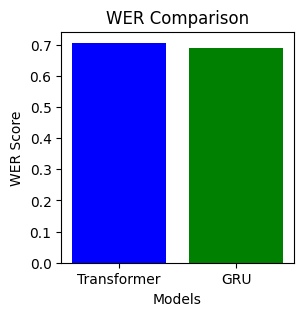

In [ ]:
#WER GRAPH
# Set the labels and scores for WER
labels = ['Transformer', 'GRU']
scores = [avg_wer_transformer, avg_wer_gru]

# Set the colors for the bars
colors = ['blue', 'green']

# Create the bar plot for WER
plt.figure(figsize=(3, 3))
plt.bar(labels, scores, color=colors)

# Set the title and axis labels
plt.title('WER Comparison')
plt.xlabel('Models')
plt.ylabel('WER Score')

# Show the plot
plt.show()

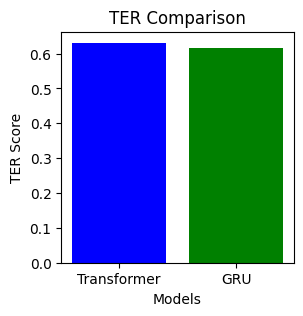

In [88]:
#TER GRAPH
# Set the labels and scores for TER
labels = ['Transformer', 'GRU']
scores = [avg_ter_transformer, avg_ter_gru]

# Set the colors for the bars
colors = ['blue', 'green']

# Create the bar plot for TER
plt.figure(figsize=(3, 3))
plt.bar(labels, scores, color=colors)

# Set the title and axis labels
plt.title('TER Comparison')
plt.xlabel('Models')
plt.ylabel('TER Score')

# Show the plot
plt.show()

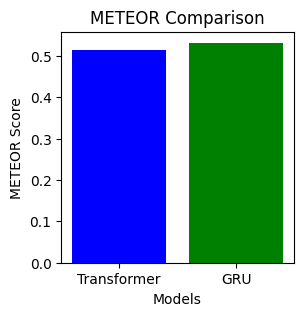

In [ ]:
#METEOR GRAPH
# Set the labels and scores for METEOR
labels = ['Transformer', 'GRU']
scores = [avg_meteor_transformer, avg_meteor_gru]

# Set the colors for the bars
colors = ['blue', 'green']

# Create the bar plot for METEOR
plt.figure(figsize=(3, 3))
plt.bar(labels, scores, color=colors)

# Set the title and axis labels
plt.title('METEOR Comparison')
plt.xlabel('Models')
plt.ylabel('METEOR Score')

# Show the plot
plt.show()

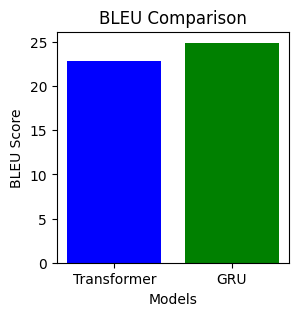

In [87]:
#BLEU GRAPH
# Set the labels and scores for BLEU
labels = ['Transformer', 'GRU']
scores = [bleu_transf.score, bleu_gru.score]

# Set the colors for the bars
colors = ['blue', 'green']

# Create the bar plot for BLEU
plt.figure(figsize=(3, 3))
plt.bar(labels, scores, color=colors)

# Set the title and axis labels
plt.title('BLEU Comparison')
plt.xlabel('Models')
plt.ylabel('BLEU Score')

# Show the plot
plt.show()